# Municipality Analysis

In [1]:
#Cargando librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
#import reverse_geocoder as rg 
#import pprint 

In [2]:
df = pd.read_csv('datasets.csv', index_col=False)
df = df.reset_index(drop=True)
df = df.drop(columns=['Unnamed: 0'])

C:\Users\OMAR\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.shape

(937785, 25)

## Some Metadata
### l6 .... l1 : Administrative Level
### surface_total: Total surface in m2
### surface_covered : Total surface covered in m2
### bathrooms
### bedrooms
### lat
### lon

## Utility Functions

In [4]:
#import os
#os.getcwd()
#from utils.utils import relocate
#from [dir].[file.py] import relocate
#from .utils imprt relocate

In [5]:
def reverseGeocode(coordinates): 
    result = rg.search(coordinates) 
    
    return result[0]['admin1'], result[0]['name']

# Dataframe must have been given reset_indexed
# Complete missing values where deparment and municipality are unknown
def relocate(df_geo):
    n = df_geo.shape[0]
    for i in tqdm(range(0,n)):
        lat = df_geo.loc[i, 'lat']
        lon = df_geo.loc[i, 'lon']
        l2 = df_geo.loc[i, 'l2']
        l3 = df_geo.loc[i, 'l3']
        if (~np.isnan(lat) and ~np.isnan(lon)) and (pd.isnull(l3) or pd.isnull(l2)):
            df_geo.loc[i, 'l2'], df_geo.loc[i, 'l3'] = reverseGeocode((lat,lon))
            
    return df_geo

#Calculates missing data and shows dataframe
def calculate_missing(df):
    s_types = df.dtypes
    missing = df.isnull().sum()
    missing_per = (df.isnull().sum()/df.shape[0])*100

    explo = pd.DataFrame({'Type' : s_types, 'Missing' : missing,
                       'Missing%' : missing_per}).sort_values(by=['Missing%', 'Type'], ascending=False)

    return explo

#Graph missing data given dataframe
def graph_missing(df):

    df_missing = calculate_missing(df)

    df_missing = df_missing.where(df_missing['Missing%'] > 25).dropna(subset=['Missing%'])

    sns.barplot(x=df_missing.index, y=df_missing['Missing%'], data=df_missing)

## Sell and Rent Counting

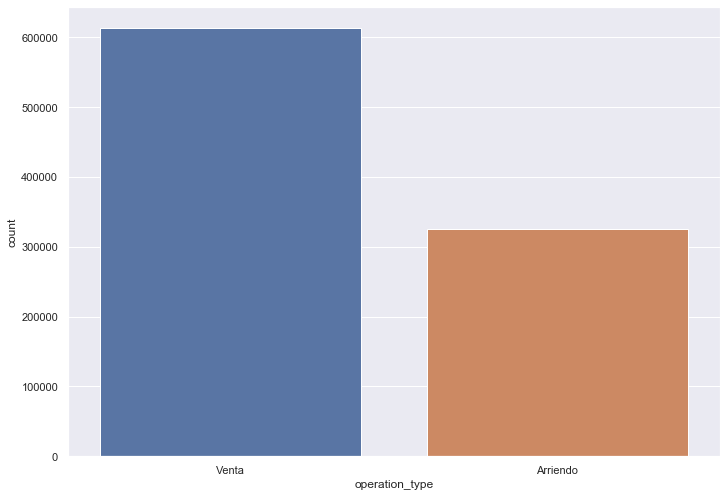

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})     
df = df.where(df['operation_type'] != 'Arriendo temporal')
sns.countplot(data = df, x = 'operation_type')

In [7]:
df_sell = df.where(df['operation_type'] == 'Venta').dropna(subset=['operation_type'])
df_rent = df.where(df['operation_type'] == 'Arriendo').dropna(subset=['operation_type'])

## Missing Values Graph - Sell

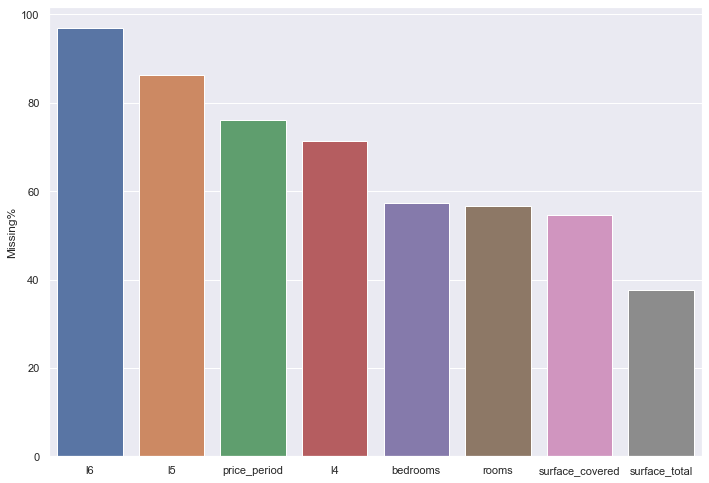

In [8]:
graph_missing(df_sell)

## Missing Values Graph - Rent

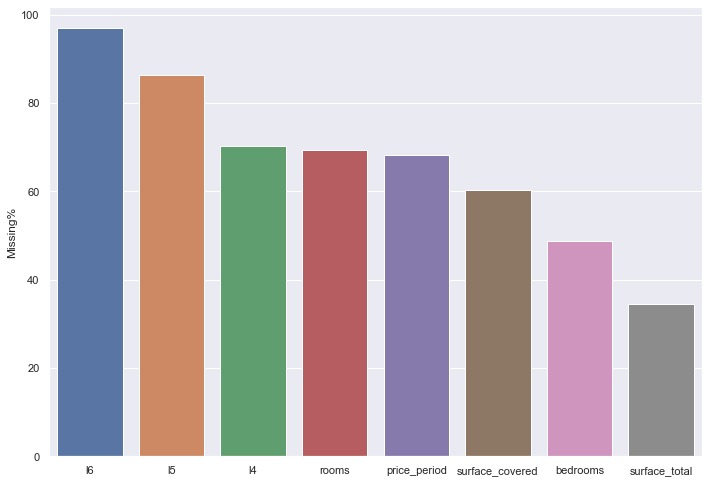

In [9]:
graph_missing(df_rent)

In [10]:
df_rent.drop(columns=['l6', 'l5', 'l4', 'rooms', 'price_period', 'surface_covered'], inplace=True)
df_sell.drop(columns=['l6', 'l5', 'l4', 'rooms', 'price_period', 'surface_covered'], inplace=True)

In [11]:
df_sell.shape

(613054, 19)

In [12]:
df_medellin = df_sell.copy()

def new_features(df):
    df_features = df.copy()
    df_features = df_features[df_features["end_date"].str.contains('9999')==False]
    df_features['price_m2'] = df['price'] / df['surface_total']
    df_features['end_date'] = pd.to_datetime(df_features.end_date)
    df_features['created_on'] = pd.to_datetime(df_features.created_on)
    df_features['delta_time'] = df_features['end_date'] - df_features['created_on'] 
    df_features['delta_time'] = df_features['delta_time'].dt.days
    
    return df_features
    
df_medellin = df_medellin[df_medellin['price']<df_medellin['price'].quantile(0.99)]
df_medellin = df_medellin[df_medellin['price'] > df_medellin['price'].quantile(0.1)]
#df_medellin = df_medellin[df_medellin['surface_total'] > 0]

df_medellin = new_features(df_medellin)
df_medellin = df_medellin[~np.isnan(df_medellin['price']) & df_medellin['price'] > 0]
df_medellin = df_medellin[df_medellin['surface_total'] > 0]

df_medellin['price'] = np.log(df_medellin['price'])

del df_medellin['delta_time']

#hue='species'
#sns.pairplot(df_medellin, height=2.5);

In [13]:
df_medellin[np.isnan(df_medellin['surface_total'])].shape

(0, 20)

In [14]:
df_medellin['l3'].value_counts()

Bogotá D.C          60884
Medellín            32749
Cali                28261
Barranquilla        26985
Manizales           11458
                    ...  
Supata                  1
El Bordo                1
Los Palmitos            1
Puerto Concordia        1
La Macarena             1
Name: l3, Length: 619, dtype: int64

## Bogota and Medellin Logarithmic Distribution  

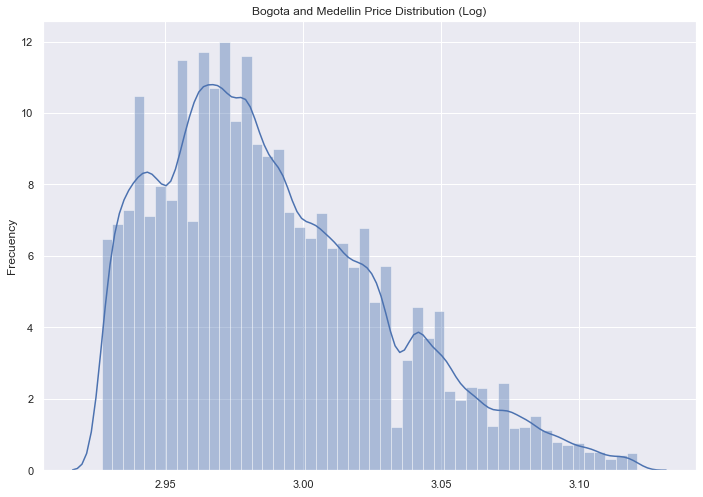

In [15]:
ax = sns.distplot(np.log(df_medellin['price']));
ax.set(xlabel='', ylabel='Frecuency',title ="Bogota and Medellin Price Distribution (Log)")
plt.show()

In [16]:
df_medellin = df_medellin.drop(columns=['id', 'ad_type', 'start_date', 'end_date', 'created_on',
                          'l1', 'l2', 'l3', 'currency', 'title', 'description', 'operation_type'])

In [17]:
df_medellin.shape

(289389, 8)

## Medellin and Bogotá Sell Correlation Matrix

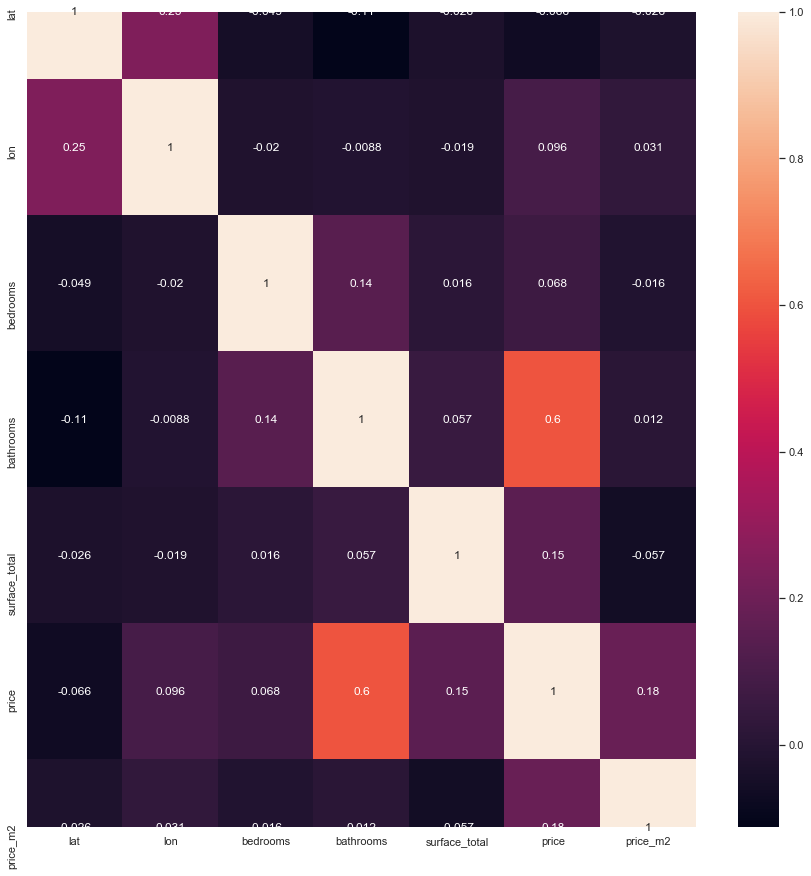

In [18]:
corr = df_medellin.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True)

## Machine Learning - Initial Model

In [19]:
X_df = df_medellin.drop('price', axis=1).copy()
Y_df = df_medellin['price'].copy()

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train_or, X_test_or, Y_train_or, Y_test_or = train_test_split(X_df, Y_df, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [22]:
# Para eliminar SettingWithCopyWarning
X_train = X_train_or.copy()
X_test = X_test_or.copy()
Y_train = Y_train_or.copy()
Y_test = Y_test_or.copy()

In [23]:
from sklearn.preprocessing import (PowerTransformer, StandardScaler, 
                                   MinMaxScaler, LabelEncoder, OneHotEncoder)

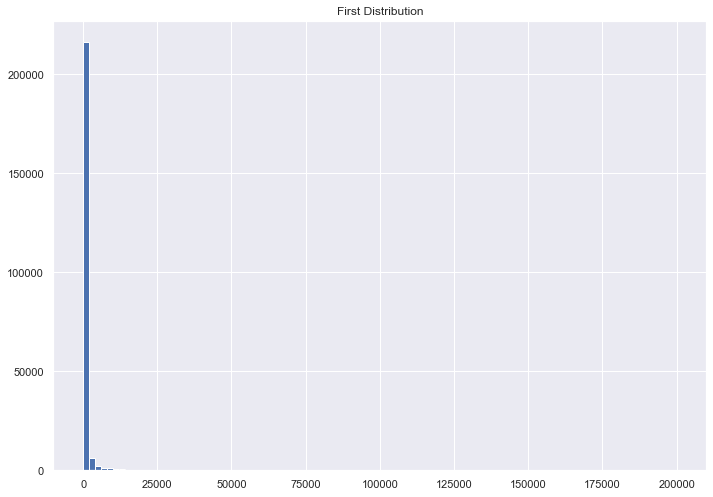

In [24]:
# Validar que todos los valores sean mayores a 0 para poder realizar la transformación.
(X_train["surface_total"]>0).sum() == len(X_train)
X_train["surface_total"].hist(bins=100)
plt.title("First Distribution")
plt.show()

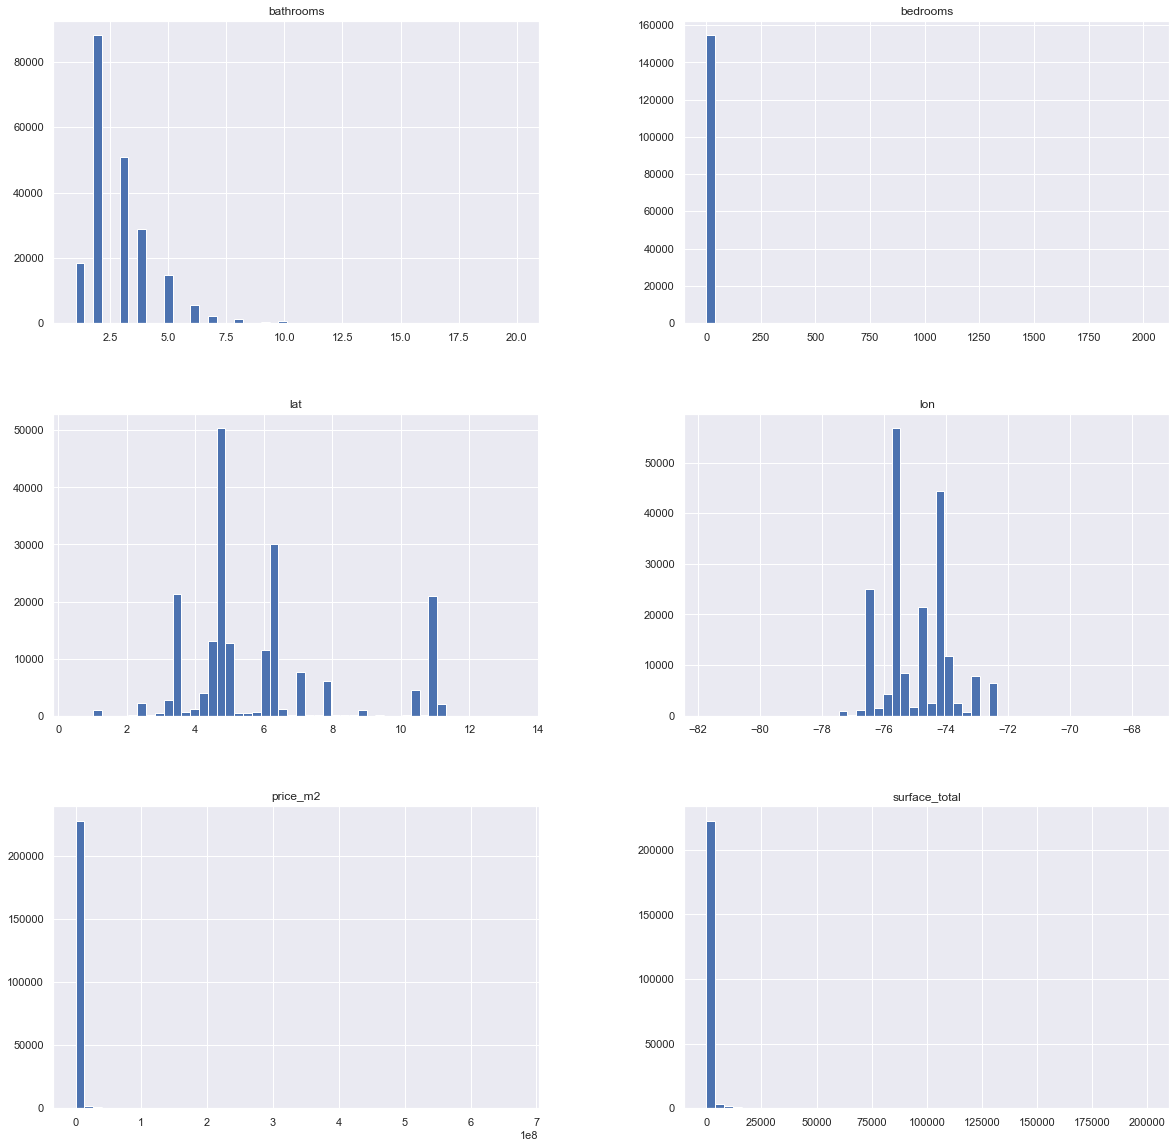

In [25]:
X_train_or.hist(bins=50, figsize=(20,20))
plt.show()

### Power Transformer Labels (Box-Cox)

Normalize and reduce scale

In [26]:
box_cox = PowerTransformer(method='box-cox') # Box-Cox object instance
box_cox.fit(X_train["surface_total"].values.reshape(-1,1)) # Box-Cox, array 2 dimensions
X_train.loc[:,"surface_total"] = box_cox.transform(X_train["surface_total"].values.reshape(-1,1)) # Transformamos el array
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,property_type,price_m2
754716,4.896848,-74.035945,NaN,5.0,1.290786,Casa,1.239474e+06
916360,4.705000,-74.028000,3.0,2.0,-2.956952,Apartamento,2.500000e+07
370778,4.100000,-73.651001,4.0,2.0,-0.130203,Casa,1.147541e+06
839510,4.745000,-74.056000,3.0,2.0,-0.837188,Apartamento,3.571429e+06
880843,NaN,NaN,NaN,3.0,0.021091,Apartamento,1.785714e+06


In [27]:
box_cox.lambdas_ # Lambdas aprendidos

array([-0.41630483])

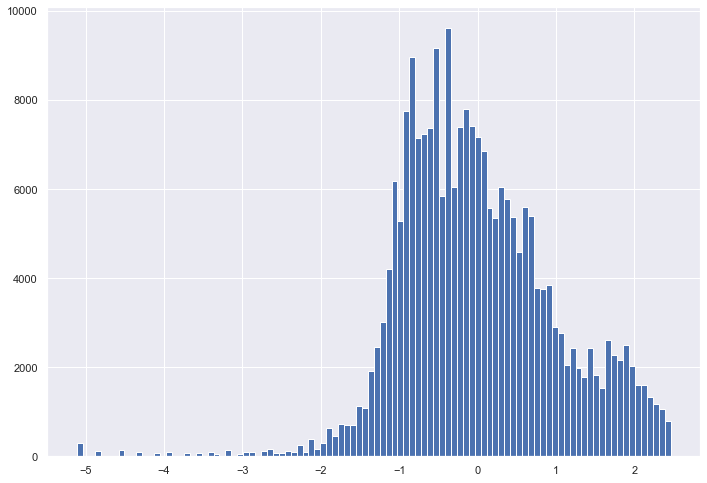

In [28]:
# Visualización de distribución
X_train["surface_total"].hist(bins=100)
plt.show()
# Se aproxima en gran medida a una distribución normal visualmente
# Nótese que los datos están centrados en 0 y pareciera que tiene desviación unitaria.

### Standard Scaler
El Standard Scaler sirve para centrar una distribución en 0 y que tenga desviación estándar unitaria.

 $$\mathbf{Z} = \frac{\mathbf{X} - \mathbf{\mu}}{\mathbf{\sigma}}$$


In [29]:
print("Classes: ", X_train['property_type'].unique()) # Clases categoricas
X_train.head()

Classes:  ['Casa' 'Apartamento' 'Lote' 'Otro' 'Finca' 'Oficina' 'Parqueadero'
 'Local comercial' 'Depósito']


,lat,lon,bedrooms,bathrooms,surface_total,property_type,price_m2
754716,4.896848,-74.035945,NaN,5.0,1.290786,Casa,1.239474e+06
916360,4.705000,-74.028000,3.0,2.0,-2.956952,Apartamento,2.500000e+07
370778,4.100000,-73.651001,4.0,2.0,-0.130203,Casa,1.147541e+06
839510,4.745000,-74.056000,3.0,2.0,-0.837188,Apartamento,3.571429e+06
880843,NaN,NaN,NaN,3.0,0.021091,Apartamento,1.785714e+06


In [30]:
le_proper_type = LabelEncoder()
le_proper_type.fit(X_train['property_type'])
X_train['property_type'] = le_proper_type.transform(X_train['property_type'])

In [31]:
ohe_proper_type = OneHotEncoder()
ohe_proper_type.fit(X_train["property_type"].values[:,None])
out = ohe_proper_type.transform(X_train["property_type"].values[:,None]) 
out_array = out.toarray()
ohe_cols_op = []
for category in ohe_proper_type.categories_[0]:
    current_class = le_proper_type.classes_[int(category)]
    col_add = "op_" + current_class
    ohe_cols_op.append(col_add)
    X_train[col_add] = out_array[:,int(category)]

X_train = X_train.drop("property_type", axis =1)

C:\Users\OMAR\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [32]:
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,price_m2,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
754716,4.896848,-74.035945,NaN,5.0,1.290786,1.239474e+06,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
916360,4.705000,-74.028000,3.0,2.0,-2.956952,2.500000e+07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370778,4.100000,-73.651001,4.0,2.0,-0.130203,1.147541e+06,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
839510,4.745000,-74.056000,3.0,2.0,-0.837188,3.571429e+06,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
880843,NaN,NaN,NaN,3.0,0.021091,1.785714e+06,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tratamiento de datos faltantes o NaN

In [33]:
from sklearn.impute import SimpleImputer
# NaNs Columns
X_train.isnull().sum()

lat                   33652
lon                   33652
bedrooms              77022
bathrooms             20194
surface_total             0
price_m2                  0
op_Apartamento            0
op_Casa                   0
op_Depósito               0
op_Finca                  0
op_Local comercial        0
op_Lote                   0
op_Oficina                0
op_Otro                   0
op_Parqueadero            0
dtype: int64

In [34]:
#Using Simple Imputer

si_bedrooms = SimpleImputer(strategy='mean')
si_bedrooms.fit(X_train["bedrooms"].values[:,None])
X_train["bedrooms"] = si_bedrooms.transform(X_train["bedrooms"].values[:,None])

si_lat = SimpleImputer(strategy='mean')
si_lat.fit(X_train["lat"].values[:,None])
X_train["lat"] = si_lat.transform(X_train["lat"].values[:,None])

si_lon = SimpleImputer(strategy='mean')
si_lon.fit(X_train["lon"].values[:,None])
X_train["lon"] = si_lon.transform(X_train["lon"].values[:,None])

si_bath = SimpleImputer(strategy='mean')
si_bath.fit(X_train["bathrooms"].values[:,None])
X_train["bathrooms"] = si_bath.transform(X_train["bathrooms"].values[:,None])

In [35]:
#Otras transformaciones
cols2scale = ['lon', 'lat', 'bedrooms', 'bathrooms', 'price_m2']
se_cols2scale = StandardScaler()
se_cols2scale.fit(X_train[cols2scale])
X_train[cols2scale] = se_cols2scale.transform(X_train[cols2scale])
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,price_m2,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
754716,-4.780117e-01,9.444525e-01,-1.981414e-16,1.515727,1.290786,-0.290666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
916360,-5.665709e-01,9.526055e-01,-1.025293e-01,-0.632642,-2.956952,2.397055,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370778,-8.458462e-01,1.339451e+00,1.205581e-01,-0.632642,-0.130203,-0.301065,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
839510,-5.481065e-01,9.238744e-01,-1.025293e-01,-0.632642,-0.837188,-0.026882,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
880843,4.099938e-16,-2.916406e-14,-1.981414e-16,0.083481,0.021091,-0.228877,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X_test['surface_total'] = box_cox.transform(X_test['surface_total'].values[:,None])


In [37]:
X_test['property_type'] = le_proper_type.transform(X_test['property_type'])

In [38]:
temp_test = ohe_proper_type.transform(X_test["property_type"].values[:,None]).toarray()
for idx, col in enumerate(ohe_cols_op):
    X_test[col] = temp_test[:,idx]

X_test = X_test.drop("property_type", axis=1)

In [39]:
X_test['bedrooms'] = si_bedrooms.transform(X_test["bedrooms"].values[:,None])
X_test['lat'] = si_lat.transform(X_test['lat'].values[:, None])
X_test['lon'] = si_lon.transform(X_test['lon'].values[:, None])
X_test['bathrooms'] = si_bath.transform(X_test['bathrooms'].values[:,None])

In [40]:
X_test[cols2scale] = se_cols2scale.transform(X_test[cols2scale])

In [41]:
assert (X_test.columns.values == X_train.columns.values).all()

In [42]:
X_test

,lat,lon,bedrooms,bathrooms,surface_total,price_m2,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
593046,4.923670e-01,1.951019e+00,-0.102529,-0.632642,-0.878759,-0.166377,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
930217,1.300015e-01,-6.286442e-01,-0.102529,0.799604,-0.102863,0.211633,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
629599,-5.684173e-01,7.607250e-01,-0.102529,-0.632642,-1.257636,-0.078715,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103171,9.087409e-01,2.554378e+00,-0.102529,-0.632642,-0.120985,-0.154976,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602608,-1.202211e+00,-1.726592e+00,-0.325617,-0.632642,-0.900200,0.193805,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241469,-5.781998e-01,9.251538e-01,-0.548704,-0.632642,-0.944473,0.668974,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100142,9.965470e-02,-6.880409e-01,-0.102529,-0.632642,-0.758884,-0.056362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
145708,4.099938e-16,-2.916406e-14,-0.102529,0.083481,0.275971,-0.066383,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11042,4.099938e-16,-2.916406e-14,0.789820,2.947973,0.929541,0.021597,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Linear Regression

In [43]:
from sklearn.linear_model import LinearRegression 
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
lin_reg.intercept_, lin_reg.coef_

(19.88230777299,
 array([-0.        ,  0.        , -0.        ,  0.18097121,  0.35008239,
         0.15861736, -0.        , -0.        ,  0.        ,  0.        ,
         0.        , -0.        ,  0.        ,  0.        ,  0.        ]))

In [44]:
Y_test_estimate = lin_reg.predict(X_test)

In [45]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [46]:
rmse = mean_squared_error(Y_test, Y_test_estimate)
print("Root Mean Square Error (RMSE)= {:.2f}".format(rmse))

Root Mean Square Error (RMSE)= 0.33


In [47]:
mae = mean_absolute_error(Y_test, Y_test_estimate)
print("Mean Absolute Error (MAE)= {:.2f}".format(mae))

Mean Absolute Error (MAE)= 0.45


In [48]:
r2 = r2_score(Y_test, Y_test_estimate)
print("R_2 = {:.3f}".format(r2))

R_2 = 0.510


### Estimated vs Real

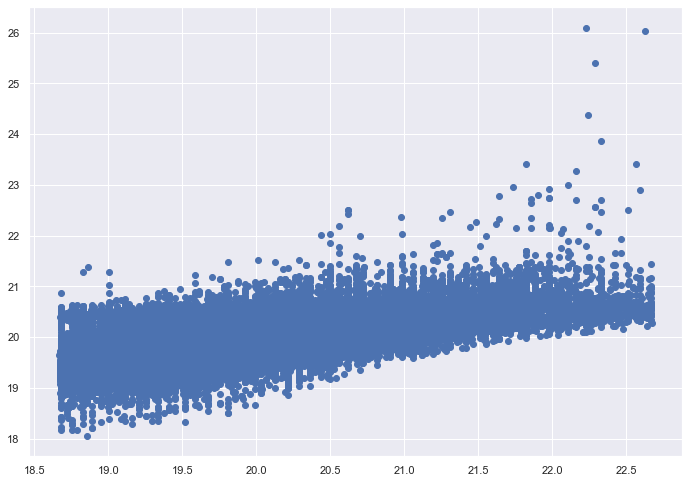

In [49]:
plt.scatter(Y_test, Y_test_estimate)

In [50]:
X_test = X_test.reset_index(drop = True)
Y_test = Y_test.reset_index(drop = True)

In [51]:
Y_test

0        18.884415
1        20.380776
2        18.921456
3        19.519293
4        19.729014
           ...    
57873    20.264400
57874    19.316769
57875    20.178539
57876    21.193269
57877    19.855765
Name: price, Length: 57878, dtype: float64

In [52]:
for i in range(0, 100):
    my_max = max(abs(Y_test_estimate))
    index_max = np.where(Y_test_estimate == my_max)[0][0]
    X_test = X_test.drop(index_max).reset_index(drop=True)
    Y_test = Y_test.drop(index_max).reset_index(drop=True)
    Y_test_estimate = np.delete(Y_test_estimate, index_max)
    

In [53]:
for i in range(0, 40):
    my_max = min(abs(Y_test_estimate))
    index_max = np.where(Y_test_estimate == my_max)[0][0]
    X_test = X_test.drop(index_max).reset_index(drop=True)
    Y_test = Y_test.drop(index_max).reset_index(drop=True)
    Y_test_estimate = np.delete(Y_test_estimate, index_max)

In [54]:
X_test

,lat,lon,bedrooms,bathrooms,surface_total,price_m2,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
0,4.923670e-01,1.951019e+00,-0.102529,-0.632642,-0.878759,-0.166377,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.300015e-01,-6.286442e-01,-0.102529,0.799604,-0.102863,0.211633,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-5.684173e-01,7.607250e-01,-0.102529,-0.632642,-1.257636,-0.078715,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.087409e-01,2.554378e+00,-0.102529,-0.632642,-0.120985,-0.154976,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.202211e+00,-1.726592e+00,-0.325617,-0.632642,-0.900200,0.193805,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57733,-5.781998e-01,9.251538e-01,-0.548704,-0.632642,-0.944473,0.668974,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57734,9.965470e-02,-6.880409e-01,-0.102529,-0.632642,-0.758884,-0.056362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
57735,4.099938e-16,-2.916406e-14,-0.102529,0.083481,0.275971,-0.066383,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57736,4.099938e-16,-2.916406e-14,0.789820,2.947973,0.929541,0.021597,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
